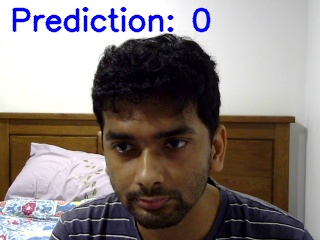

Webcam ready!


In [1]:
import cv2
# import nanocamera as nano
from IPython.display import display, Image
import time
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image as PILImage
import numpy as np

# Initialize the camera NOTE: Uncomment this for jetson nano
# camera = nano.Camera(camera_type=1, device_id=0, flip=1, width=320, height=240, fps=30)
# display_handle = display(None, display_id=True)
# print('USB Camera ready? - ', camera.isReady())

# NOTE: Delete this later. Initialize the camera using OpenCV.
camera = cv2.VideoCapture(0)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
display_handle = display(None, display_id=True)
if not camera.isOpened():
    print("Error: Could not open webcam.")
else:
    print('Webcam ready!')


# Load model and checkpoint
num_classes = 2
checkpoint = './ryan_albaro_uribe_resnet34.pth'
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# model.load_state_dict(torch.load(checkpoint))
# using gpu//////////
model = model.to("cuda")

# Define the transformations
transform = transforms.Compose([
    # transforms.ToPILImage(),  # Convert from NumPy array (OpenCV format) to PIL Image
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.436, 0.385, 0.345], std=[0.296, 0.270, 0.261])  # Normalize
])

# Set model to evaluation mode
model.eval()

# Camera capture loop
with torch.no_grad():
    # while camera.isReady():
    while camera.isOpened():
        try:
            # Read the camera image
            # frame = camera.read()
            ret, frame = camera.read()
            if not ret:
                print("Failed to capture frame")
                break

            # Convert to PIL Image for transformations
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = PILImage.fromarray(frame_rgb)

            # Apply transformations
            transformed_frame = transform(pil_image).unsqueeze(0).to("cuda")

            # Get the prediction
            pred = model(transformed_frame)
            pred_class = pred.argmax(1).item()  # Get the predicted class index

            # # Overlay the prediction on the frame
            # cv2.putText(frame, f'Prediction: {pred_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
            #             1, (255, 0, 0), 2, cv2.LINE_AA)

            # Display the frame (convert back to JPEG format)
            _, jpeg_frame = cv2.imencode('.jpeg', frame)
            display_handle.update(Image(data=jpeg_frame.tobytes()))
        except KeyboardInterrupt:
            break

# Clean up camera resources
camera.release()
cv2.destroyAllWindows()